# **Задание Lite**

Используйте готовый ноутбук с кластеризацией базы покупок интернет-магазина.

1. Удалите из выборки все строки про доставку.
2. Выведите две гистограммы:
  - 2.1. Распределения размеров кластеров: сколько корзин
  - 2.2 Распределение количества уникальных позиций в кластере
3. Напишите продвинутую функцию визуализации одного выбранного кластера:
  - 3.1 Размер кластера
  - 3.2 Количество уникальных позиций
  - 3.3 Позиции, которые есть минимум в 20% корзин
  - 3.4 Уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания монобрендовых и монотоварных закупок

# Подключение библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import to_categorical
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Кластеризация корзин интернет-магазина**

## **Работа с таблицей**

### Загрузка базы

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/УИИ/Кластеризация/online_carts.csv')

### Редактирование базы

In [ ]:
# Просмотр таблицы
df.head()

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


**Перед выполнением задачи, необходимо предобработка данной таблицы (датафрейма):**

*   Удаление ненужных столбцов
*   Удаление ненужных строк (unknown) из столбца "Валовая прибыль"
*   Удаление строк содержащих информацию о дате



### Удаление ненужного столбца

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head(2)

,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN


### Добавление новой колонки Дата и изменение NaN на unknown

In [ ]:
# Чтобы из базы вытащить временные данные в отдельную колонку
df.insert(0, column='Дата', value=[x for x in range(len(df))])

df = df.fillna('unknown')

df.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,1,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,2,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,3,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,4,unknown,unknown,unknown,unknown


### Создание флага начала корзины и изменнение значений в столбце **Дата**

In [ ]:
# Series.str.contains() содержится ли шаблон в строке, присутствующей в базовых данных данного объекта серии.

df[df['Валовая прибыль'].str.contains('MCOSM')].head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
10,10,MCOSM13113,26236,9,unknown
22,22,MCOSM13113,1929,4,unknown
166,166,MCOSM4885,350,2,unknown
168,168,MCOSM4996,9436,4,unknown
172,172,MCOSM5963,8625,6,unknown


In [ ]:
df['Валовая прибыль'].str.contains('MCOSM').head()

0    False
1    False
2    False
3    False
4    False
Name: Валовая прибыль, dtype: bool

In [ ]:
# Индексы строк, где есть информация в формате даты
date_list = list(df[df['Валовая прибыль'].str.contains('\d\d.\d\d.2019')].index)
# Пример индексов
print(date_list[:10])

[9, 21, 28, 703, 1703, 2617, 3067, 3538, 4344, 5524]


In [ ]:
idx = 0

for i in range(len(df)):
  if i in date_list:
    idx = i
  df['Дата'][i] = df['Валовая прибыль'][idx]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Дальнейшая очистка таблицы

In [ ]:
# Первые строки где есть слово - Период
df = df.drop(df[df['Дата'].str.contains('Период')].index, axis=0)

In [ ]:
# Пустые строки между корзинами
df = df.drop(df[df['Валовая прибыль'].str.contains('unknow')].index, axis=0)

In [ ]:
# Строки-даты, которые находятся в столбце корзин
# Это тот же список data_list
df = df.drop(df[df['Валовая прибыль'] == df['Дата']].index)

In [ ]:
# Обновление индекса
df.reset_index(inplace=True)

In [ ]:
df = df.drop('index', axis=1)

In [ ]:
df.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown


# 1. Удалите из выборки все строки про доставку

In [ ]:
df = df.drop(df[df['Валовая прибыль'].str.contains('доставк')].index, axis=0)  
df.reset_index(inplace=True)  # Обновим индекс
df = df.drop('index',axis=1) # Удалим ненужную колонку

In [ ]:
# Вывод на печать обновленной базы (первые 30 строчек)
df.head(30)

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown
5,01.01.2019 0:00:00,XPERT (HS71) машинка для стрижки волос,12989,1,unknown
6,01.01.2019 0:00:00,ЛП ТНА САВАЖ ПАНАШ 250 мл,988,1,unknown
7,01.01.2019 0:00:00,перчатки (50 пар) винил размер S черные,319,1,unknown
8,01.01.2019 0:00:00,MCOSM13113,1929,4,unknown
9,01.01.2019 0:00:00,OLLIN SERVICE LINE Увлаж. Бальзам для волос 10...,483,1,unknown


In [ ]:
# Есть ли доставка. Проверка
df[df['Валовая прибыль'].str.contains("доставк")]

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4


**Колонка "Валовая прибыль" не содержит больше строк с составляющей "доставка"**

# 2. Выведите две гистограммы:


Создаем списое индексов всех флагов

In [ ]:
cart_list  = list(df[df['Валовая прибыль'].str.contains('MCOSM')].index)
cafre_list = list(df[df['Валовая прибыль'].str.contains('CAFRE')].index)

print(len(cart_list))
print(len(cafre_list))

13567
74


### 2.0.1 Формирование корзины

In [ ]:
# Удаление пустых корзин, которые ранее содержали только услуги по доставке 

for i in cart_list[0:-1]:
  if (i+1) == cart_list[cart_list.index(i)+1]:
    cart_list.remove(i)

In [ ]:
# Список всех корзин
carts = []

cart = []                   # Текущая карзина
i = 0                       # Счетчик для прохождения по базе
val = df['Валовая прибыль'] # Будем работать с этим столбцом - Валовая прибыль
allPositions = []           # Пустой список позиций

while i != len(df):
  if i in cart_list:
    if i != cart_list[-1]:  # Если не последний индекс-флаг
      ind = cart_list.index(i)

      while i < cart_list[ind+1]-1:
        cart.append(val[i+1])
        allPositions.append(val[i+1])
        i += 1
    else:                     # Если же текущий индекс-флаг последний в списке
      while i <(len(df)-1):
        cart.append(val[i+1])
        allPositions.append(val[i+1])
        i += 1
  
    carts.append(cart)
    cart=[]
  else:
    i += 1

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

88

In [ ]:
# Проверка, если у нас количество корзин совпадает с количеством флагов корзин
print(len(carts)==len(cart_list))   
print('Количество всех позиций: ', len(allPositions)) 
print('Содержание корзины: ', carts[0])

True
Количество всех позиций:  77645
Содержание корзины:  ['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные']


In [ ]:
# Чистка пустых корзины
carts_null = []
for i,cart in enumerate(carts):
  if (len(cart) > 0):
    carts_null.append(cart)

carts=carts_null

# Количество корзин
len(carts)

12638

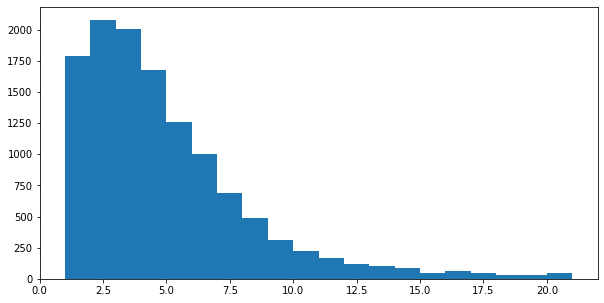

In [ ]:
# Гистограмма размеров корзин
plt.figure(figsize=(10,5))
plt.hist([len(c) for c in carts], 20, [1, 21])
plt.show()

### 2.0.2 Создаем объект LabelEncoder 

In [ ]:
labelEncoder = LabelEncoder()
labelEncoder.fit(allPositions) # Обрабатываем все имеющиеся позиции товаров

LabelEncoder()

In [ ]:
# Посчитаем количество уникальных товаров
maxPositionsCount = max(labelEncoder.transform(allPositions)) + 1
print(maxPositionsCount)

7587


In [ ]:
# Создание списока индексов для каждой корзины
cartsIndexes = [labelEncoder.transform(c) for c in carts]

In [ ]:
# Проверка
n = 100                 
print(carts[n])      
print(cartsIndexes[n])

['CRISTALINAS Mikado Арома-диффузор для жилых помещений с ароматом ванильного крема 18 мл', 'Kapous Обесцвечивающая пудра BLEACHING POWDER с ментолом 500 гр', 'Kapous Обесцвечивающий порошок для волос Dust Free серии Studio 500 гр', 'OLLIN X-PLEX №1 X-Bond Booster Активатор связей 250мл', 'Кондиционер для окрашенных волос Color Radiance 1000 мл. Londa', 'расческа DEWAL Эконом для начеса с пластмассовым хвостиком черная с белым нейлоновой щетиной', 'расческа TRIUMPH комбинированная антистатик 17,8 см.', 'щетка Dewal Beauty серия Эко массажная с деревянным штифтом овальная DBW436ECO']
[1505 1903 1906 3626 4569 7294 7332 7544]


### 2.0.3 Дополнительные функции

In [ ]:
# Функция преобразования вектора по приницпу bag of words
def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)
  for x in trainVector:
    out[x] = 1
  return out

In [ ]:
# Функция преобразования выборки (обучающей или проверочной) по принципу Bag of words
def changeSetTo01(trainSet, wordsCount):
  out = []
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))
  return np.array(out)

### 2.0.4 Создание выборки

In [ ]:
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount)

In [ ]:
# Проверка
n = 100
print(carts[n])
print(cartsIndexes[n])
print(carts01[n])

['CRISTALINAS Mikado Арома-диффузор для жилых помещений с ароматом ванильного крема 18 мл', 'Kapous Обесцвечивающая пудра BLEACHING POWDER с ментолом 500 гр', 'Kapous Обесцвечивающий порошок для волос Dust Free серии Studio 500 гр', 'OLLIN X-PLEX №1 X-Bond Booster Активатор связей 250мл', 'Кондиционер для окрашенных волос Color Radiance 1000 мл. Londa', 'расческа DEWAL Эконом для начеса с пластмассовым хвостиком черная с белым нейлоновой щетиной', 'расческа TRIUMPH комбинированная антистатик 17,8 см.', 'щетка Dewal Beauty серия Эко массажная с деревянным штифтом овальная DBW436ECO']
[1505 1903 1906 3626 4569 7294 7332 7544]
[0. 0. 0. ... 0. 0. 0.]


### 2.0.5 Кластеризация

In [ ]:
clustersCount = 25           # Указываем количество кластеров
cur_time = time.time()
kmean = KMeans(clustersCount)
kmean.fit(carts01)
labels = kmean.labels_
npCarts = np.array(carts)
print('Время обработки при количестве классов: ', clustersCount, 'равно: ', round(time.time() - cur_time,2),'c') 

Время обработки при количестве классов:  25 равно:  129.08 c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
print(labels)
print(clustersCount)                                            # Отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера
print(clusterSize)
#Выведем номер кластера и его размер
for i, s in enumerate(clusterSize):
  print(i, s)  

[ 1  0  1 ... 23  1  1]
25
[26, 10025, 26, 49, 119, 281, 1, 1, 45, 22, 1, 15, 81, 206, 176, 1, 158, 1, 34, 1, 488, 266, 366, 248, 1]
0 26
1 10025
2 26
3 49
4 119
5 281
6 1
7 1
8 45
9 22
10 1
11 15
12 81
13 206
14 176
15 1
16 158
17 1
18 34
19 1
20 488
21 266
22 366
23 248
24 1


### 2.0.6 Дополнительные функции для вывода информации

In [ ]:
# Функция которая возвращаем список позиций кластера и количество каждой позиции
def getCluster(x):
  clasterSize = x.shape[0]
  sumX = np.sum(x, axis=0)
  sumX /= clasterSize

  positions = []
  positionValues = []

  for i in range(sumX.shape[0]):
    if (sumX[i] > 0):
      position = labelEncoder.inverse_transform([i])
      positions.append(position)
      positionValues.append(sumX[i])
  return positions, positionValues

In [ ]:
# Создание списока размеров каждого кластера
clusterSize = [sum(labels==i) for i in range(0, clustersCount)]

In [ ]:
for clussterNumber in range(len(clusterSize)):
  if clusterSize[clussterNumber] > 5:
    pos, posVal = getCluster(carts01[labels==clussterNumber])
    print("Покупок:", clusterSize[clussterNumber])
    print("Позиций:", len(pos))
    pos = np.array(pos)
    posVal = np.array(posVal)
    indexes = posVal > 0.6
    indexedPos = pos[indexes]
    indexedPosVal = posVal[indexes]

    # Отображение
    for i in range(len(indexedPos)):
      print(f"{round(100 * indexedPosVal[i])} % {indexedPos[i]}")
    
    print()
    print()

Покупок: 26
Позиций: 1368
62 % ['Бальзам для ежедневного применения 1000 мл. Curex Classic']
62 % ['Оксигент для волос 6% ESTEL PRINCESS ESSEX 1000 мл.']
62 % ['Хромоэнергетический комплекс']
77 % ['Шампунь для ежедневного применения 1000 мл. Curex Classic']


Покупок: 10025
Позиций: 6611


Покупок: 26
Позиций: 916
62 % ['12/89 Стойкая крем-краска специальный блонд жемчуж']
65 % ['4/0 Стойкая крем-краска шатен']
73 % ['5/0 Стойкая крем-краска светлый шатен']
69 % ['6/0 Стойкая крем-краска темный блонд']
69 % ['6/71 Стойкая крем-краска темный блонд коричнево-пе']
62 % ['6/77 Стойкая крем-краска темный блонд интенсивно-коричневый']
81 % ['7/0 Стойкая крем-краска блонд']
73 % ['8/38 Стойкая крем-краска светлый блонд золотисто-жемчужный']
77 % ['Окислительная эмульсия  6% Londa 1000 мл.']


Покупок: 49
Позиций: 382
67 % ['Бальзам для интенсивного увлажнения волос OTIUM AQUA 200 мл.']
69 % ['Комфорт-маска для интенсивного увлажнения волос OTIUM AQUA 300 мл.']
96 % ['Шампунь для интенсивного

## 2.1. Распределения размеров кластеров: сколько корзин

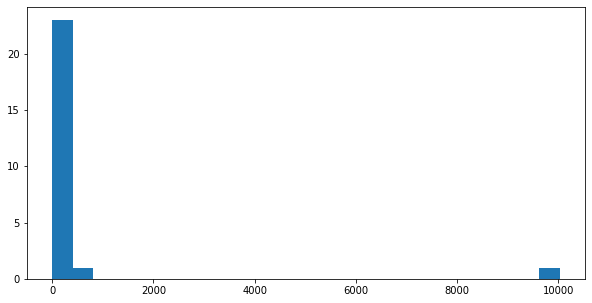

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(clusterSize, 25)
plt.show()

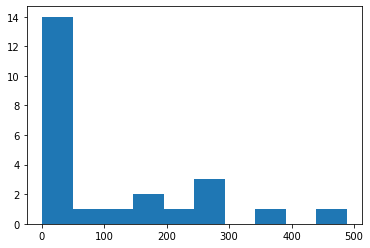

In [ ]:
npClusterSize=np.array(clusterSize)
plt.hist(npClusterSize[npClusterSize<500])
plt.show()

## 2.2 Распределение количества уникальных позиций в кластере

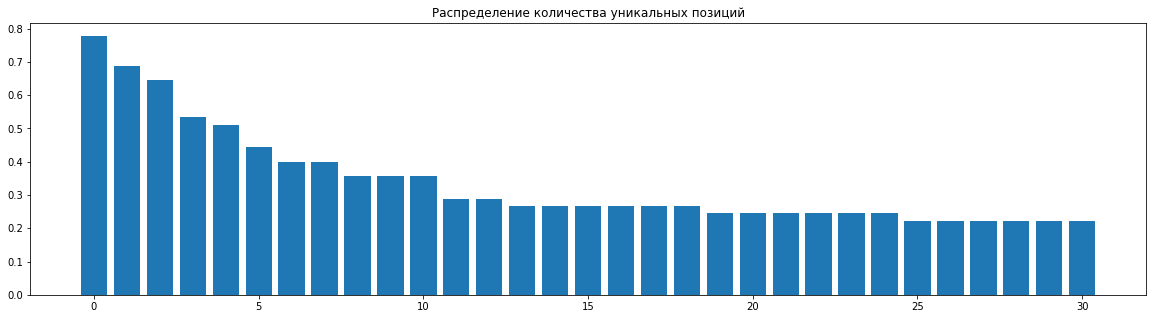

In [ ]:
# Построение гиcтограммы распределения количества уникальных позиций для 8 кластеров

clusterNumber = 8
pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере                               
pos = np.array(pos)                                      # Преобразуем в numpy
posVal = np.array(posVal)                                # Преобразуем в numpy
indexes = posVal > 0.2                                   # Берем те позиции, доля которых составляет больше 20%
indexedPos = pos[indexes]                                # Выбираем эти позиции из pos 
indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

# Отобразим гистограмму распределения количества уникальных позиций
plt.figure(figsize=(20,5))
plt.title('Распределение количества уникальных позиций')
plt.bar([i for i in range(len(indexedPosVal))], sorted(indexedPosVal, reverse=True)) # Вывод гистограммы в порядке убывания спроса на позицию
plt.show()

# 3 Напишите продвинутую функцию визуализации одного выбранного кластера:
3.1. Размер кластера

3.2. Количество уникальных позиций

3.3. Позиции, которые есть минимум в 20% корзин

3.4. Уникальные слова в описаниях позиций, которые встречаются минимум в 20% 
позиций, для отслеживания монобрендовых и монотоварных закупок

In [ ]:
# Функция  визуализации одного выбранного класса

def visualCluster(clusterNumber, VisPos = True):           # Второй параметр определяет необходимость вывода полной информации
  pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
  print("КЛАСТЕР: ", clusterNumber)
  print("Размер кластера:", clusterSize[clusterNumber])    # Выводим размер текущего кластера
  print("Количество уникальных позиций:", len(pos))        # Выводим общее число позиций в текущем кластере
  pos = np.array(pos)                                      # Преобразуем в numpy
  posVal = np.array(posVal)                                # Преобразуем в numpy
  indexes = posVal > 0.2                                   # Берем индексы тех позиций, доля которых позиции, которые есть минимум в 20% корзин
  indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
  indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций
  print("Количество, которые есть в 20% корзин:", len(indexedPos))
  # Отображаем уникальные слова в описаниях позиций, которые встречаются минимум в 20 позиций%
  if VisPos == True:
    print("Вот эти позиции:")
    for i in range(len(indexedPos)):
      print(indexedPos[i], sep="")

  # Выделим уникальные слова в описаниях позиций, которые встречаются минимум в 20% 
  indexedList = []                   
  for i in range(len(indexedPos)): 
    x1 = list(indexedPos[i])             
    x2 = list(str(x1[0]).split(' '))     # Преобразование позиции в список слов
    indexedList.append(x2)

  brand = []                               # Здесь будут храниться "брендовые" слова кластера       
  for i1 in range(len(indexedList)):
    for i2 in range(len(indexedList[i1])):
      word = indexedList[i1][i2]
      count = 0
      for i3 in range(len(indexedList)):
        if word in indexedList[i3]:
          if not(word in brand):            # Проверка есть ли уже текущее слово в брендовом списке
            count += 1
      if count > 0.2*len(indexedList):      # Проверка 20% содержания слова
        if not(any(char in ".,:;!_*+()/#¤%&123456789)" for char in word)): # Исключаем "мусорные слова" 
          if not(word == 'мл'):                                   
            brand.append(word)

  list_brand = ' '.join(brand)
  return list_brand    


In [ ]:
# Проверим работу функции на 8 кластере
list_brand = visualCluster(8, VisPos = True)
print()
print('Бренд кластера: ', list_brand)

КЛАСТЕР:  8
Размер кластера: 45
Количество уникальных позиций: 1693
Количество, которые есть в 20% корзин: 31
Вот эти позиции:
['AQUATIKA Маска-смузи  увлажнение Likato 250мл']
['AQUATIKA Софт-Бальзам увлажнение Likato 250мл']
['AQUATIKA Софт-Бальзам увлажнение Likato 400мл']
['AQUATIKA Софт-Шампунь с алоэ Likato 250мл']
['DELIKATE Софт-Шампунь Уход для чувствительной кожи головы Likato 250мл']
['KERALESS Кератин-маска Likato 250 мл']
['KERALESS Кератин-спрей Likato 100 мл']
['KERALESS Кератин-шампунь Likato 250мл']
['OLLIN PERFECT HAIR 15 в 1 Несмываемый крем-спрей 250 мл']
['RECOVERY Маска-Смузи восстановление Likato 250 мл']
['RECOVERY Масло восстановление Likato 100 мл']
['RECOVERY Софт-Бальзам восстановление Likato 250мл']
['RECOVERY Шампунь восстановление с протеинами Likato 250 мл']
['WELLNESS Кондиционер для жирных волос Likato 250мл']
['WELLNESS Маска для тонких и жирных волос Likato 250мл']
['WELLNESS Минеральный шампунь с витаминами Likato 250мл']
['WELLNESS Минеральный шамп

In [ ]:
# Выведем брендовую информацию по всем классам в сжатом виде
for clusterNumber in range(len(clusterSize)):
  if clusterSize[clusterNumber] > 100:
    list_brand = visualCluster(clusterNumber, VisPos = False)
    print('Бренд ', clusterNumber,'-го кластера: ', list_brand)
    print()

КЛАСТЕР:  1
Размер кластера: 10025
Количество уникальных позиций: 6611
Количество, которые есть в 20% корзин: 0
Бренд  1 -го кластера:  

КЛАСТЕР:  4
Размер кластера: 119
Количество уникальных позиций: 694
Количество, которые есть в 20% корзин: 2
Бренд  4 -го кластера:  Бальзам-сияние для окрашенных волос OTIUM COLOR LIFE Деликатный шампунь

КЛАСТЕР:  5
Размер кластера: 281
Количество уникальных позиций: 499
Количество, которые есть в 20% корзин: 1
Бренд  5 -го кластера:  Эмульсия для удаления краски с волос

КЛАСТЕР:  13
Размер кластера: 206
Количество уникальных позиций: 818
Количество, которые есть в 20% корзин: 3
Бренд  13 -го кластера:  Кератиновая вода для волос ESTEL KERATIN маска Кератиновый шампунь

КЛАСТЕР:  14
Размер кластера: 176
Количество уникальных позиций: 2075
Количество, которые есть в 20% корзин: 7
Бренд  14 -го кластера:  Стойкая крем-краска  волос ml

КЛАСТЕР:  16
Размер кластера: 158
Количество уникальных позиций: 597
Количество, которые есть в 20% корзин: 1
Бренд

# Выводы:

1. Были удалены  все строки про доставку. В некоторых корзинах находились исключительно позиции по услугам доставки, после удаления которых корзины оказались пустыми. Это привело к зацикливанию исходной части кода программы по формированию корзин. В связи с этим, дополнительно был написан код по удалению пустых корзин. 

2. Выведены две гистограммы:

 - распределения размеров кластеров по числу корзин;
 - распределения количества уникальных позиций в выбранном кластере.

3. Согласно заданию написана функция визуализации одного кластера, позволяющая вычислять:

  - размер кластера;
  - количество уникальных позиций в кластере;
  - позиции, которые есть минимум в 20% корзин;
  - уникальные слова в описаниях позиций, которые встречаются минимум в 20%
 позиций, для отслеживания монобрендовых и монотоварных закупок.


4. Для эксперимента было выбрано количество кластеров, равное 25 для ускорения работы кода и получить обозримые и интерпретируемые результаты.